## Acessando os Dados

In [1]:
import pandas as pd

data = pd.read_csv("https://raw.githubusercontent.com/ifood/ifood-data-business-analyst-test/master/ml_project1_data.csv")
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


# Criando Informações

In [2]:
#import pandas as pd
from datetime import datetime

def create_information(data=None):
    """
    Build new information for the iFood Data Business Analysis dataframe, with 
    old information, and drop unesed columns.

    :param pd.DataFrame data: iFood Data Business Analysis dataframe.

    :returns: DataFrame with processed data.
    :rtype: pd.DataFrame
    """
    
    # if data == None:
    #     print("No parameter provided")
    #     return 0    

    df = data
    
    # Creating the costumer time at the company
    df["Time as Costumer"] = df["Dt_Customer"].apply(lambda d: (datetime.today() - datetime.strptime(d, "%Y-%m-%d")).days)

    # Creating age information
    df["Age"] = df["Year_Birth"].apply(lambda y: 2020 - y)

    col_names = df.columns.to_list()
    
    # Remove unused columns
    col_names.remove("Year_Birth")
    col_names.remove("Dt_Customer")

    # Remove categorical columns
    col_names.remove("Marital_Status")
    col_names.remove("Education")

    # Include sorted categorical columns
    col_names = ["Marital_Status", "Education"] + col_names

    return df[col_names]

In [3]:

df = create_information(data)
df.head()

,Marital_Status,Education,ID,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Time as Costumer,Age
0,Single,Graduation,5524,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,2942,63
1,Single,Graduation,2174,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,2392,66
2,Together,Graduation,4141,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,2591,55
3,Together,Graduation,6182,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,2418,36
4,Married,PhD,5324,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,2440,39


# Pré Processamento dos Dados

In [4]:
from sklearn import preprocessing

def encoding_categoricals(df=None):
    """
    This module encodes the iFood dataframe categorical columns (encodes mean 
    transform categorical features into numerical features).

    :param pd.DataFrame data: iFood Data Business Analysis dataframe.

    :returns: DataFrame with categorical columns encoded.
    :rtype: pd.DataFrame
    """
    encoders = []
    col_names = df.columns
    for col in col_names:
        if type(df[col].iloc[0]) == str:
            # Creating and fitting the encoder
            le = preprocessing.LabelEncoder()
            le.fit(df[col])
            # Replace and storing data/encoder
            encoders.append(le)
            df.loc[:,col] = le.transform(df[col])

    return df, encoders

In [5]:

df, encoders = encoding_categoricals(df) # Step 2 -> Pipeline


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [6]:
df.head()

,Marital_Status,Education,ID,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Time as Costumer,Age
0,4,2,5524,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,2942,63
1,4,2,2174,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,2392,66
2,5,2,4141,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,2591,55
3,5,2,6182,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,2418,36
4,3,4,5324,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,2440,39


In [7]:

def remove_not_informative(df=None):
    """
    Remove non informative columns from dataframe.

    :param pd.DataFrame data: iFood Data Business Analysis dataframe.

    :returns: DataFrame without non informative features.
    :rtype: pd.DataFrame
    """
    
    informative_columns = []
    for col in df.columns:
        col_std = df[col].std()
        if col_std != 0:
            informative_columns.append(col)
    
    try:
        informative_columns.remove("ID")
    except: pass

    return df[informative_columns]

In [8]:

df = remove_not_informative(df)  # Step 3 -> Pipeline


In [9]:
# from sklearn import preprocessing

def normalize_dataset(df=None):
    """
    This module normalizes the provided dataframe. **Guarantee that the provided
    dataframe has only numerical columns**.

    :param pd.DataFrame data: iFood Data Business Analysis dataframe.

    :returns: normalized DataFrame.
    :rtype: pd.DataFrame
    """

    column_names = df.columns

    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(df[column_names[:-1]])

    new_df = pd.DataFrame(data=X, columns=column_names[:-1])
    df = pd.concat([new_df, df["Response"]], axis=1)

    return df, scaler


In [10]:

df, scaler = normalize_dataset(df) # Step 4 -> Pipeline


In [11]:
df.head()

,Marital_Status,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Time as Costumer,Response
0,0.251004,-0.350141,0.234063,-0.825218,-0.929894,0.307039,0.983781,1.551577,1.679702,2.462147,1.476500,0.843207,0.349414,1.409304,2.510890,-0.550785,0.693904,-0.28014,-0.28383,-0.28014,-0.262111,-0.11651,-0.097282,2.388846,1.531185,1
1,0.251004,-0.350141,-0.234559,1.032559,0.906934,-0.383664,-0.870479,-0.636301,-0.713225,-0.650449,-0.631503,-0.729006,-0.168236,-1.110409,-0.568720,-1.166125,-0.130463,-0.28014,-0.28383,-0.28014,-0.262111,-0.11651,-0.097282,-0.418612,-1.190545,0
2,1.180340,-0.350141,0.769478,-0.825218,-0.929894,-0.798086,0.362723,0.570804,-0.177032,1.345274,-0.146905,-0.038766,-0.685887,1.409304,-0.226541,1.295237,-0.542647,-0.28014,-0.28383,-0.28014,-0.262111,-0.11651,-0.097282,-0.418612,-0.205773,0
3,1.180340,-0.350141,-1.017239,1.032559,-0.929894,-0.798086,-0.870479,-0.560857,-0.651187,-0.503974,-0.583043,-0.748179,-0.168236,-0.750450,-0.910898,-0.550785,0.281720,-0.28014,-0.28383,-0.28014,-0.262111,-0.11651,-0.097282,-0.418612,-1.061881,0
4,-0.678332,1.428354,0.240221,1.032559,-0.929894,1.550305,-0.389085,0.419916,-0.216914,0.155164,-0.001525,-0.556446,1.384715,0.329427,0.115638,0.064556,-0.130463,-0.28014,-0.28383,-0.28014,-0.262111,-0.11651,-0.097282,-0.418612,-0.953012,0


In [12]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def fill_ausent_data(df=None):
    """
    Utilize the beta release of iterative imputer to fill ausent data on dataset.
    
    :param pd.DataFrame data: iFood Data Business Analysis dataframe.

    :returns: DataFrame with NaN data interpolated.
    :rtype: pd.DataFrame
    """

    # Create the imputer
    imputer = IterativeImputer(random_state=0)
    df.iloc[:,:] = imputer.fit_transform(df)

    return df


In [13]:

df = fill_ausent_data(df)


In [14]:
df.dropna().shape

(2240, 26)

In [15]:
df.head()

,Marital_Status,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Time as Costumer,Response
0,0.251004,-0.350141,0.234063,-0.825218,-0.929894,0.307039,0.983781,1.551577,1.679702,2.462147,1.476500,0.843207,0.349414,1.409304,2.510890,-0.550785,0.693904,-0.28014,-0.28383,-0.28014,-0.262111,-0.11651,-0.097282,1.0,1.531185,1.0
1,0.251004,-0.350141,-0.234559,1.032559,0.906934,-0.383664,-0.870479,-0.636301,-0.713225,-0.650449,-0.631503,-0.729006,-0.168236,-1.110409,-0.568720,-1.166125,-0.130463,-0.28014,-0.28383,-0.28014,-0.262111,-0.11651,-0.097282,0.0,-1.190545,0.0
2,1.180340,-0.350141,0.769478,-0.825218,-0.929894,-0.798086,0.362723,0.570804,-0.177032,1.345274,-0.146905,-0.038766,-0.685887,1.409304,-0.226541,1.295237,-0.542647,-0.28014,-0.28383,-0.28014,-0.262111,-0.11651,-0.097282,0.0,-0.205773,0.0
3,1.180340,-0.350141,-1.017239,1.032559,-0.929894,-0.798086,-0.870479,-0.560857,-0.651187,-0.503974,-0.583043,-0.748179,-0.168236,-0.750450,-0.910898,-0.550785,0.281720,-0.28014,-0.28383,-0.28014,-0.262111,-0.11651,-0.097282,0.0,-1.061881,0.0
4,-0.678332,1.428354,0.240221,1.032559,-0.929894,1.550305,-0.389085,0.419916,-0.216914,0.155164,-0.001525,-0.556446,1.384715,0.329427,0.115638,0.064556,-0.130463,-0.28014,-0.28383,-0.28014,-0.262111,-0.11651,-0.097282,0.0,-0.953012,0.0


#Pipeline de Dados

## Funções de Pipeline

In [2]:
import pandas as pd

from datetime import datetime
from sklearn import preprocessing

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import train_test_split

def create_information(data=None):
    """
    Build new information for the iFood Data Business Analysis dataframe, with 
    old information, and drop unesed columns.

    :param pd.DataFrame data: iFood Data Business Analysis dataframe.

    :returns: DataFrame with processed data.
    :rtype: pd.DataFrame
    """
    
    # if data == None:
    #     print("No parameter provided")
    #     return 0    

    df = data

    # Creating the costumer time at the company
    df["Time as Costumer"] = df["Dt_Customer"].apply(lambda d: (datetime.today() - datetime.strptime(d, "%Y-%m-%d")).days)

    # Creating age information
    df["Age"] = df["Year_Birth"].apply(lambda y: 2020 - y)

    col_names = df.columns.to_list()
    
    # Remove unused columns
    col_names.remove("Year_Birth")
    col_names.remove("Dt_Customer")

    # Remove categorical columns
    col_names.remove("Marital_Status")
    col_names.remove("Education")
    col_names.remove("Response")

    # Include sorted categorical columns
    col_names = ["Marital_Status", "Education"] + col_names + ["Response"]

    return df[col_names]




def encoding_categoricals(df=None):
    """
    This module encodes the iFood dataframe categorical columns (encodes mean 
    transform categorical features into numerical features).

    :param pd.DataFrame data: iFood Data Business Analysis dataframe.

    :returns: DataFrame with categorical columns encoded.
    :rtype: pd.DataFrame
    """
    encoders = []
    col_names = df.columns
    for col in col_names:
        if type(df[col].iloc[0]) == str:
            # Creating and fitting the encoder
            le = preprocessing.LabelEncoder()
            le.fit(df[col])
            # Replace and storing data/encoder
            encoders.append(le)
            df.loc[:,col] = le.transform(df[col])

    return df, encoders


def remove_not_informative(df=None):
    """
    Remove non informative columns from dataframe.

    :param pd.DataFrame data: iFood Data Business Analysis dataframe.

    :returns: DataFrame without non informative features.
    :rtype: pd.DataFrame
    """
    
    informative_columns = []
    for col in df.columns:
        col_std = df[col].std()
        if col_std != 0:
            informative_columns.append(col)
    
    try:
        informative_columns.remove("ID")
    except: pass

    return df[informative_columns]


def normalize_dataset(df=None):
    """
    This module normalizes the provided dataframe. **Guarantee that the provided
    dataframe has only numerical columns**.

    :param pd.DataFrame data: iFood Data Business Analysis dataframe.

    :returns: normalized DataFrame.
    :rtype: pd.DataFrame
    """

    column_names = df.columns

    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(df[column_names[:-1]])

    new_df = pd.DataFrame(data=X, columns=column_names[:-1])
    df = pd.concat([new_df, df["Response"]], axis=1)

    return df, scaler



def fill_ausent_data(df=None):
    """
    Utilize the beta release of iterative imputer to fill ausent data on dataset.
    
    :param pd.DataFrame data: iFood Data Business Analysis dataframe.

    :returns: DataFrame with NaN data interpolated.
    :rtype: pd.DataFrame
    """

    # Create the imputer
    imputer = IterativeImputer(random_state=0)
    df.iloc[:,:] = imputer.fit_transform(df)

    return df


def my_pipeline(data=None):
    """
    """

    df = create_information(data) # Step 1 -> Pipeline
    print("Step 1 - Creating information...")

    df, encoders = encoding_categoricals(df) # Step 2 -> Pipeline
    print("Step 2 - Encoding categories...")

    df = remove_not_informative(df)  # Step 3 -> Pipeline
    print("Step 3 - Removing non informative...")

    df, scaler = normalize_dataset(df) # Step 4 -> Pipeline
    print("Step 4 - Normalizing the dataset...")

    df = fill_ausent_data(df) # Step 5 -> Pipeline
    print("Step 5 - Imputing data at NaN...")

    X_train, X_test, y_train, y_test = train_test_split(
        df.iloc[:,:-1], df.iloc[:,-1], test_size=0.33, random_state=42)
    print("Step 6 - Train test splitting...")

    return X_train, X_test, y_train, y_test


## Rodando o Pipeline de pre processamento

In [3]:

X_train, X_test, y_train, y_test = my_pipeline(data)


Step 1 - Creating information...
Step 2 - Encoding categories...
Step 3 - Removing non informative...
Step 4 - Normalizing the dataset...


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Step 5 - Imputing data at NaN...
Step 6 - Train test splitting...


In [4]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1500, 25), (740, 25), (1500,), (740,))

## KMeans Personas

In [5]:
!pip install -U yellowbrick

     |████████████████████████████████| 266kB 2.8MB/s 
  Found existing installation: yellowbrick 0.9.1
    Uninstalling yellowbrick-0.9.1:
      Successfully uninstalled yellowbrick-0.9.1


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


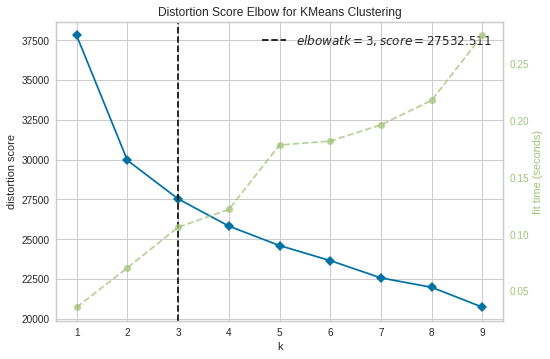

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fd45bd67e48>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=True)

In [6]:

from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer

kelbow_visualizer(KMeans(random_state=4), X_train, k=(1, 10))

In [7]:

col_names = X_train.columns.to_list()[:-2]
last_columns = X_train.columns.to_list()[-2:]

X_ = X_train[last_columns + col_names] 

km = KMeans(n_clusters=3, random_state=4).fit(X_)

clusters = km.predict(X_)

In [8]:
import numpy as np 
import plotly.graph_objects as go

data_y, data_x = {}, {}

for cluster in np.unique(clusters).tolist():
    data_y[str(cluster)] = []
    data_x[str(cluster)] = []

for col in X_.columns:
    for cluster in np.unique(clusters).tolist():
        new_data_y = X_[col][clusters == cluster].dropna()
        data_x[str(cluster)] += [col] * len(new_data_y)
        data_y[str(cluster)] += new_data_y.tolist()

fig = go.Figure()
for cluster in np.unique(clusters).tolist():
    fig.add_trace(go.Box(
        x=data_x[str(cluster)],
        y=data_y[str(cluster)],
        name=str(cluster)
    ))

fig.update_layout(
    boxmode='group' # group together boxes of the different traces for each value of x
)
fig.show()

# Classifier

In [11]:
!pip install xgboost==1.2.0

     |████████████████████████████████| 148.9MB 71kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


## Tratar o balanceamento de classes

In [12]:
100 * round( sum(y_train) / len(y_train), 2 )

15.0

In [13]:
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [14]:
100 * round( sum(y_resampled) / len(y_resampled), 2 )

50.0

## Criando o modelo de classificação

In [16]:
import xgboost as xgb

model = xgb.XGBClassifier(n_estimators=150, max_depth=8, gamma=1.5)

model.fit(X_resampled, y_resampled)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Avaliação do Modelo

In [17]:
import plotly.express as px
from sklearn.metrics import roc_curve, auc

y_score = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_score)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [18]:
from sklearn.metrics import confusion_matrix

fig = go.Figure()

thresholds = [k * 0.01 for k in range(int(1/0.01))]
negative, positive = [], []
for t in thresholds:
    cf_matrix = confusion_matrix(y_test, y_score > t, normalize="true")
    negative.append(cf_matrix[0,0])
    positive.append(cf_matrix[1,1])

fig.add_trace(go.Scatter(
    x=thresholds,
    y=negative,
    name="Label 0"
))

fig.add_trace(go.Scatter(
    x=thresholds,
    y=positive,
    name="Label 1"
))

fig.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



[Text(51.0, 0.5, 'True Label'), Text(0.5, 28.5, 'Predicted Label')]

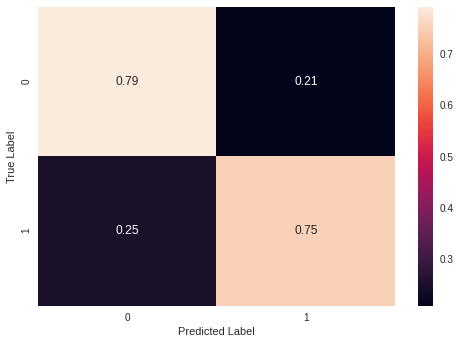

In [19]:
import seaborn as sns

cf_matrix = confusion_matrix(y_test, y_score > 0.1, normalize="true")

pt = sns.heatmap(cf_matrix, annot=True)
pt.set(xlabel="Predicted Label", ylabel = "True Label")

## PyCaret This :)

In [ ]:
!pip install pycaret

In [ ]:
from pycaret.utils import version
from pycaret.classification import *
version()

from pycaret.utils import enable_colab
enable_colab()

In [ ]:
version()

In [ ]:
df_PyCaret = pd.DataFrame(X_resampled)
df_PyCaret["target"] = y_resampled == 1.0

df_PyCaret.head()

In [ ]:
clf1 = setup(data=df_PyCaret, target="target")

In [ ]:
best = compare_models(include=["gbc", "et", "xgboost", "lightgbm", "rf"], n_select=5)

In [ ]:
best

In [ ]:
tunned_best = [tune_model(m) for m in best]

In [ ]:
tunned_best

In [ ]:
blender_specific = blend_models(estimator_list = tunned_best, method = 'soft')

In [ ]:
plot_model(blender_specific, plot="confusion_matrix")

In [ ]:
plot_model(tunned_best[3], plot="confusion_matrix")

In [ ]:
plot_model(tunned_best[], plot="class_report")

In [ ]:
plot_model(tunned_best[], plot="pr")

## Avaliando dados nunca utilizados

In [ ]:
import plotly.express as px
from sklearn.metrics import roc_curve, auc

y_score = predict_model(tunned_best[1], data=X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score["Score"].dropna())

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [ ]:
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix

fig = go.Figure()

thresholds = [k * 0.001 for k in range(int(1/0.001))]
negative, positive = [], []
for t in thresholds:
    cf_matrix = confusion_matrix(y_test, y_score["Score"].dropna() > t, normalize="true")
    negative.append(cf_matrix[0,0])
    positive.append(cf_matrix[1,1])

fig.add_trace(go.Scatter(
    x=thresholds,
    y=negative,
    name="Label 0"
))

fig.add_trace(go.Scatter(
    x=thresholds,
    y=positive,
    name="Label 1"
))

fig.show()